# Introdução ao OCR - Parte 2

### Importando as bibliotecas necessárias

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from collections import Counter
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

### Obtendo os dados de Captcha

In [2]:
# !curl -LO https://github.com/AakashKumarNain/CaptchaCracker/raw/master/captcha_images_v2.zip

!tar -xf captcha_images_v2.zip 

In [3]:
#!unzip -qq captcha_images_v2.zip # Caso a opção acima não funcione, ou esteja usando Unix-based systems

Exemplo baseado na documentação da Keras API e o exemplo dado em https://keras.io/examples/vision/captcha_ocr/

### Carregando imagens e metadados

In [4]:
# Path para o diretória
data_dir = Path("./captcha_images_v2/")

# Obtendo lista de imagens e informações das mesmas
images = sorted(list(map(str, list(data_dir.glob("*.png")))))
labels = [img.split(os.path.sep)[-1].split(".png")[0] for img in images]
characters = set(char for label in labels for char in label)
characters = sorted(list(characters))

print("Número de imagens encontradas: ", len(images))
print("Número de labels encontrados: ", len(labels))
print("Número de caracteres únicos: ", len(characters))
print("Caracteres presentes: ", characters)

Número de imagens encontradas:  1040
Número de labels encontrados:  1040
Número de caracteres únicos:  19
Caracteres presentes:  ['2', '3', '4', '5', '6', '7', '8', 'b', 'c', 'd', 'e', 'f', 'g', 'm', 'n', 'p', 'w', 'x', 'y']


In [5]:
# Batch size para treino e validação
batch_size = 16

# Dimensões das imagens
img_width = 200
img_height = 50

# Fator de downsampling das amostras por blocos de convolução
# Temos 2 blocos de convolução e 2 de pooling (fator de downsampling 2)
# Portanto, o downsampling total tem um fator 4
downsample_factor = 4

# Tamanho máximo do captcha, obtido pelo máximo entre as amostras
max_length = max([len(label) for label in labels])
print(f"Tamanho máximo do captcha entre as amostras é: {max_length}")

Tamanho máximo do captcha entre as amostras é: 5


### Pré-processamento

In [6]:
# Mapping characters to integers
char_to_num = layers.StringLookup(
    vocabulary=list(characters), mask_token=None
)

In [7]:
# Mapping integers back to original characters
num_to_char = layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True
)

In [8]:
def split_data(images, labels, train_size=0.9, shuffle=True):
    # 1. Get the total size of the dataset
    size = len(images)
    # 2. Make an indices array and shuffle it, if required
    indices = np.arange(size)
    if shuffle:
        np.random.shuffle(indices)
    # 3. Get the size of training samples
    train_samples = int(size * train_size)
    # 4. Split data into training and validation sets
    x_train, y_train = images[indices[:train_samples]], labels[indices[:train_samples]]
    x_valid, y_valid = images[indices[train_samples:]], labels[indices[train_samples:]]
    return x_train, x_valid, y_train, y_valid


# Splitting data into training and validation sets
x_train, x_valid, y_train, y_valid = split_data(np.array(images), np.array(labels))


def encode_single_sample(img_path, label):
    # 1. Read image
    img = tf.io.read_file(img_path)
    # 2. Decode and convert to grayscale
    img = tf.io.decode_png(img, channels=1)
    # 3. Convert to float32 in [0, 1] range
    img = tf.image.convert_image_dtype(img, tf.float32)
    # 4. Resize to the desired size
    img = tf.image.resize(img, [img_height, img_width])
    # 5. Transpose the image because we want the time
    # dimension to correspond to the width of the image.
    img = tf.transpose(img, perm=[1, 0, 2])
    # 6. Map the characters in label to numbers
    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
    # 7. Return a dict as our model is expecting two inputs
    return {"image": img, "label": label}

In [9]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = (
    train_dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

validation_dataset = tf.data.Dataset.from_tensor_slices((x_valid, y_valid))
validation_dataset = (
    validation_dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

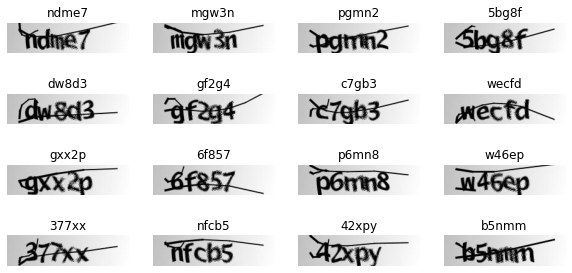

In [10]:
_, ax = plt.subplots(4, 4, figsize=(10, 5))
for batch in train_dataset.take(1):
    images = batch["image"]
    labels = batch["label"]
    for i in range(16):
        img = (images[i] * 255).numpy().astype("uint8")
        label = tf.strings.reduce_join(num_to_char(labels[i])).numpy().decode("utf-8")
        ax[i // 4, i % 4].imshow(img[:, :, 0].T, cmap="gray")
        ax[i // 4, i % 4].set_title(label)
        ax[i // 4, i % 4].axis("off")
plt.show()

Exemplo a partir de https://keras.io/examples/vision/captcha_ocr/